In [1]:
#Need this to add libraries in parent folder
import sys
sys.path.append('..')
sys.path.append('.')
sys.path.append('../lib')

In [1136]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md
import lib.wavemode as wm
import lib.plume as plm

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv
import lib.plot.table as plttbl
import lib.plot.plotplume as pltplm

import os
import math
import numpy as np

In [1150]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(wm)
importlib.reload(plm)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)
importlib.reload(plttbl)
importlib.reload(pltplm)

<module 'lib.plot.plotplume' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/plotplume.py'>

### Load data

In [560]:
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input('analysisinput.txt')
#path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5"
path='M06_th45'

In [5]:
numframe

2000

In [6]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

### transform frame

In [7]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields
dflow = ft.transform_flow(dflow,vshock)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


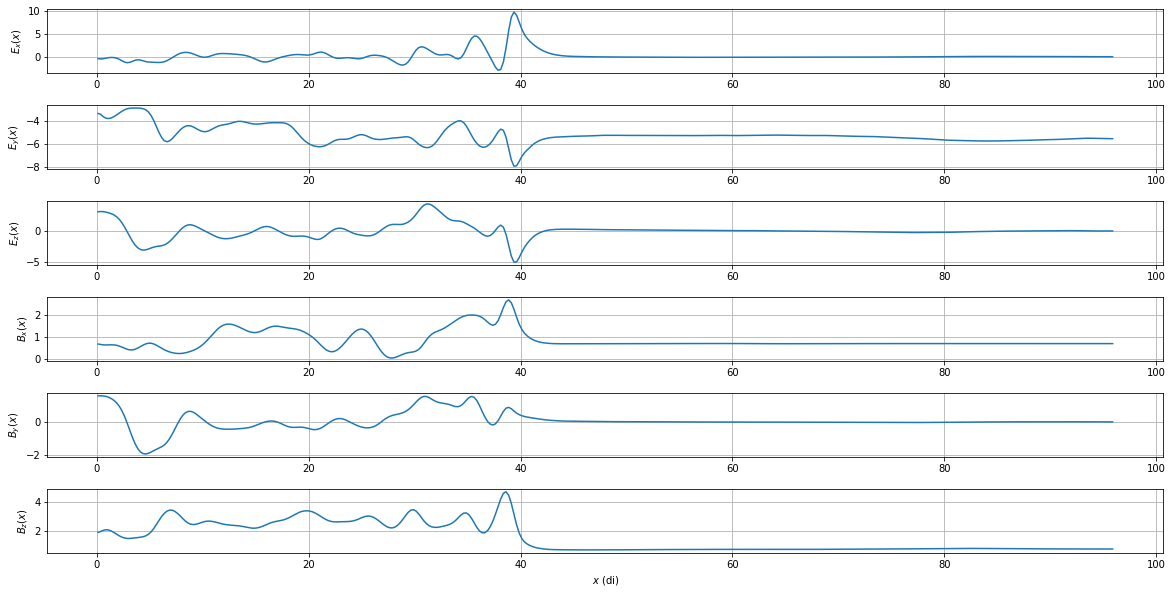

In [8]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### select x region to analyze

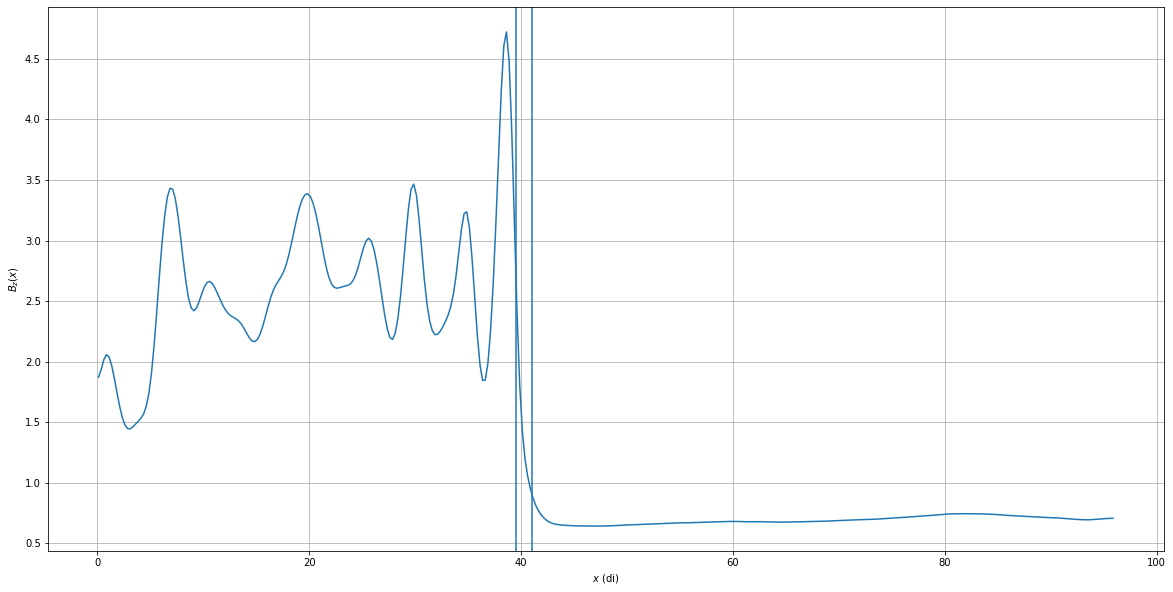

In [9]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startvalramp = 39.5#lower bound for metadata = 1 (di)
endvalramp = 41. #upper bound for metadata = 1 (di)

midrampx = (startvalramp+endvalramp)/2.
midrampidx = ao.find_nearest(dfields['bz_xx'],midrampx)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'bz', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startvalramp, axvx2 = endvalramp)

### get fluctuations

In [10]:
dflow.keys()

dict_keys(['ux', 'ux_xx', 'ux_yy', 'ux_zz', 'uy', 'uy_xx', 'uy_yy', 'uy_zz', 'uz', 'uz_xx', 'uz_yy', 'uz_zz', 'id', 'Vframe_relative_to_sim'])

In [11]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)
dflowfluc = anl.remove_average_flow_over_yz(dflow)

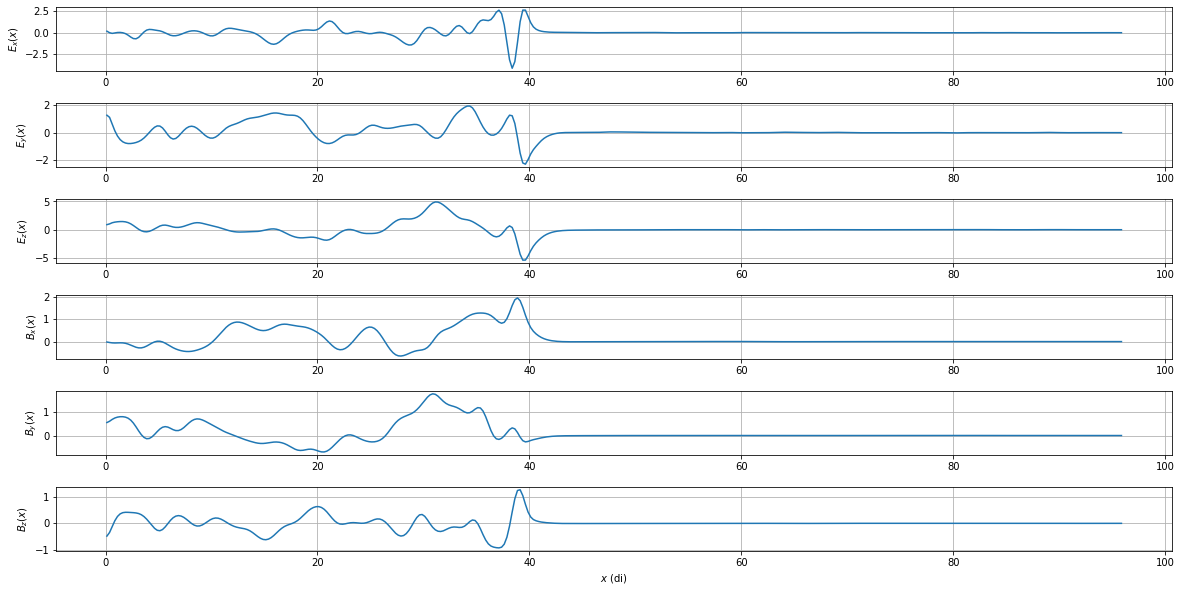

In [12]:
plt1d.plot_all_fields(dfieldsfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### look at average yz averaged fields

In [15]:
dfieldsavg = anl.get_average_fields_over_yz(dfields)

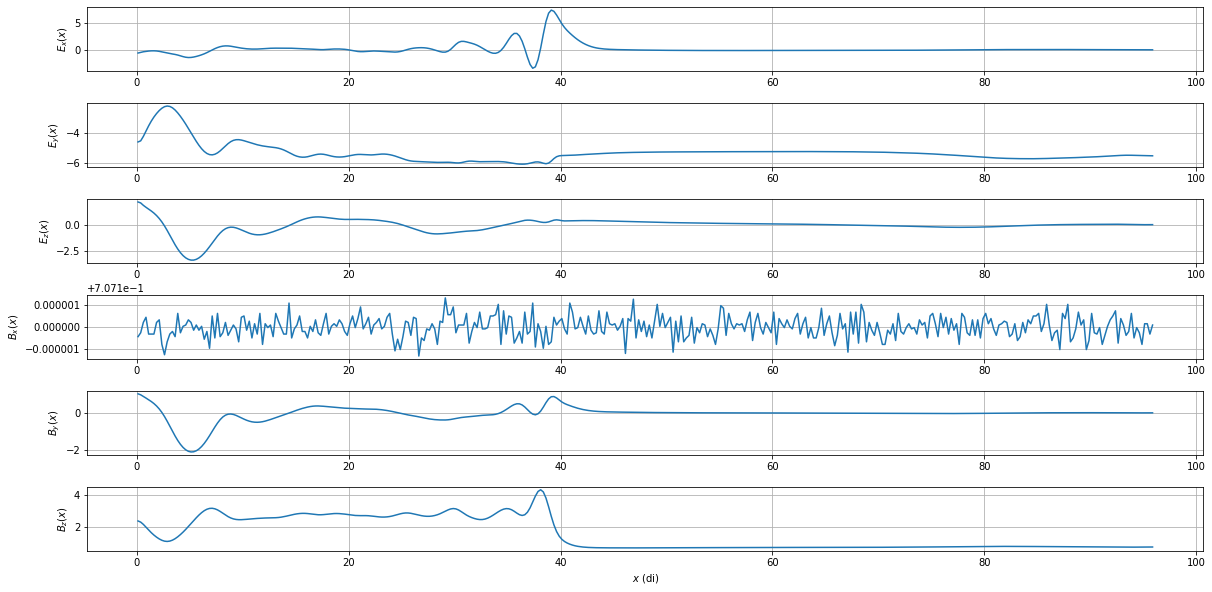

In [16]:
plt1d.plot_all_fields(dfieldsavg, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Test routine that checks all predicted wave modes and sees if they are alfvenic

In [29]:
#pick some test slice in the simulation
xx = 40.

#look at potential wavemodes
fieldkey = 'bz'
kxlist, kylist, kzlist, kxplotlist, wltplotlist, prcntmaxlist = anl.find_potential_wavemodes(dfields,fieldkey,xx,cutoffconst=.1)

In [30]:
xxidx = ao.find_nearest(dfields['bz_xx'],xx)

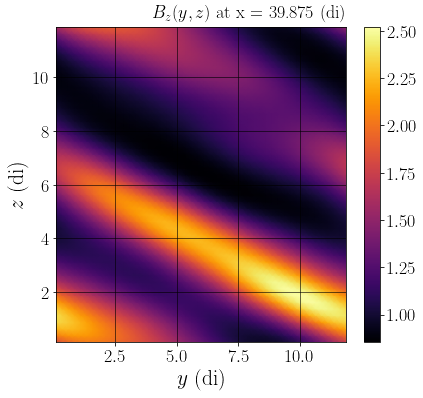

In [31]:
plt2d.make_field_pmesh(dfields,fieldkey,'yz',takeaxisaverage=False, xxindex=xxidx)
plt2d.make_field_pmesh(dfields,fieldkey,'yz',takeaxisaverage=False, xxindex=xxidx, flnm = 'm06_th45xpos'+str(xx)+'pmesh')

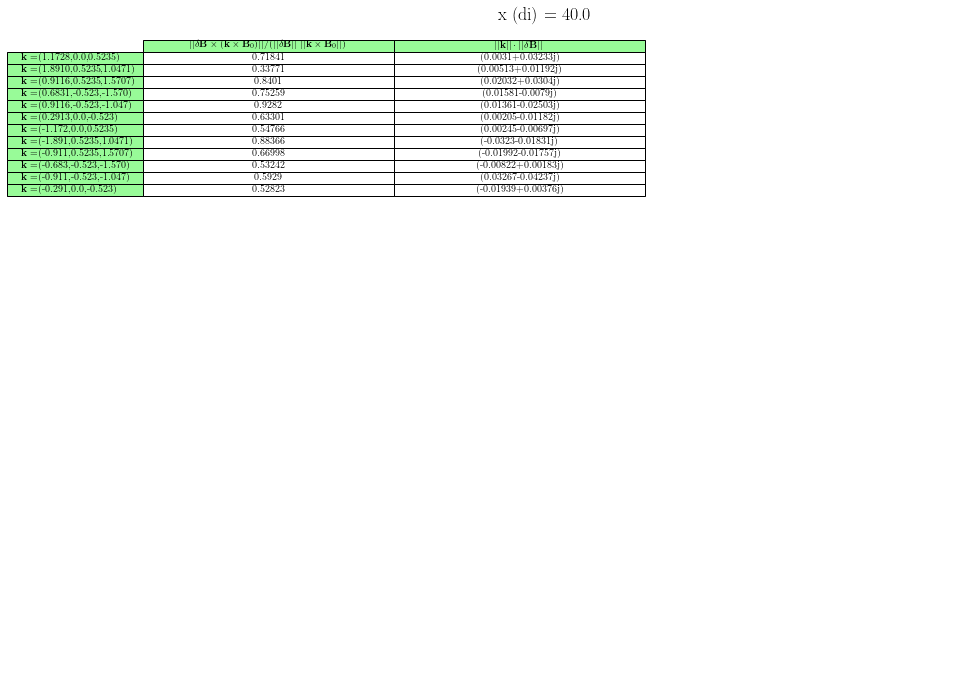

In [32]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

#build list of k's to test
klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

#test given k's
results, kxexpected, delBlist, delElist = anl.alfven_wave_check(dfields,dfieldsfluc,klist,xx)

#build and make table
results_table = [[np.round(results[i][j][1], 5) for j in range(0,len(results[i]))] for i in range(0,len(results))]
#results_table = [[results[j][1]] for j in range(0,len(results))]
collbls = [r'$|| \delta \mathbf{B} \times (\mathbf{k} \times \mathbf{B}_0)|| / (|| \delta \mathbf{B} ||$ $||\mathbf{k} \times \mathbf{B}_0||)$',
          r'$||\mathbf{k}|| \cdot ||\delta \mathbf{B}||$']
rowlbls = ['$\mathbf{k} = $('+str(klist[i][0])[0:6]+','+str(klist[i][1])[0:6]+','+str(klist[i][2])[0:6]+')' for i in range(0,len(klist))]
plttbl.make_table(rowlbls,collbls,results_table,ttl='x (di) = '+str(xx),flnm='m06_th45xpos'+str(xx)+'planewaveprops')
plttbl.make_table(rowlbls,collbls,results_table,ttl='x (di) = '+str(xx),flnm='')

### Look at field aligned coordinates

In [33]:
#compute field aligned coorinates
B0 = anl.get_B_yzavg(dfields,xxidx)
dxgrid = dfields['bz_xx'][1]-dfields['bz_xx'][0]
xlim = [xx-dxgrid,xx+dxgrid]
epar,eperp1,eperp2 = anl.compute_field_aligned_coord(dfields,xlim,ylim,zlim)

In [556]:
epar

array([0.4401509 , 0.4014379 , 0.80319035], dtype=float32)

In [565]:
xx = 40
xlim = [xx-dxgrid,xx+dxgrid]
epartemp,_,_ = anl.compute_field_aligned_coord(dfields,xlim,ylim,zlim)
epartemp

array([0.4401509 , 0.4014379 , 0.80319035], dtype=float32)

In [34]:
#pick a wavemode (from above table)
i = 5
k = [kxlist[i],kylist[i],kzlist[i]]
delB = np.abs(delBlist[i])

In [35]:
_ = np.asarray([epar,eperp1,eperp2]).T
changebasismatrix = np.linalg.inv(_)

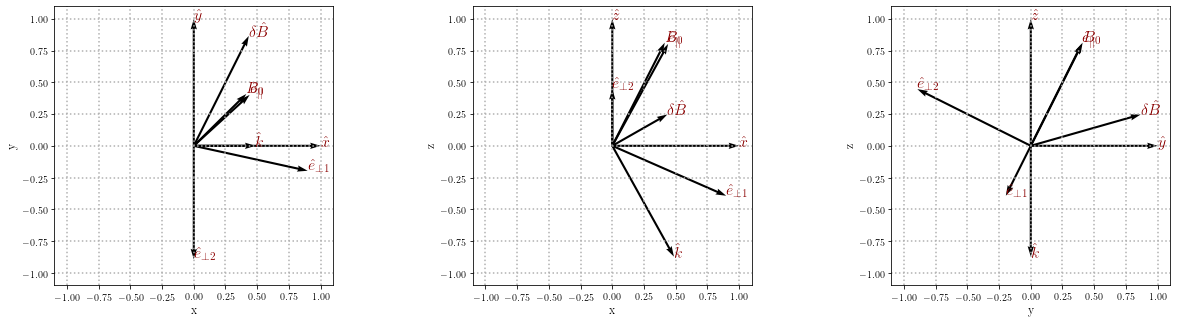

In [36]:
pltdebug.plot_fluc_and_coords(B0,k,delB,epar,eperp1,eperp2,flnm = '')

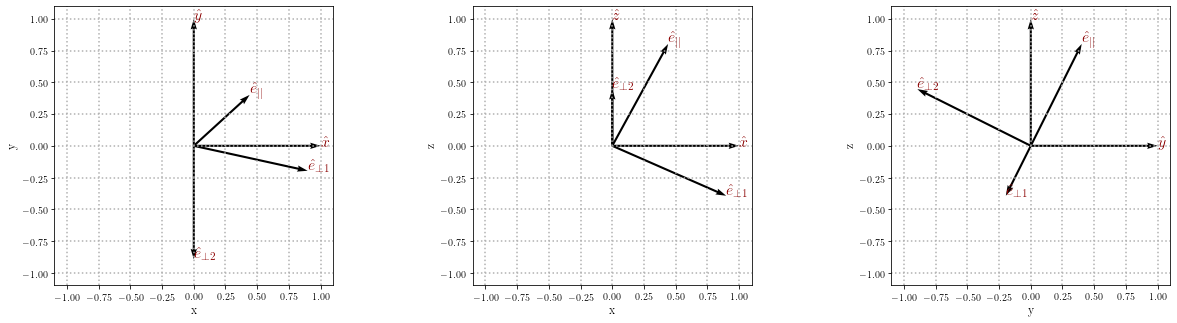

In [37]:
pltdebug.plot_coords(epar,eperp1,eperp2,flnm = '')

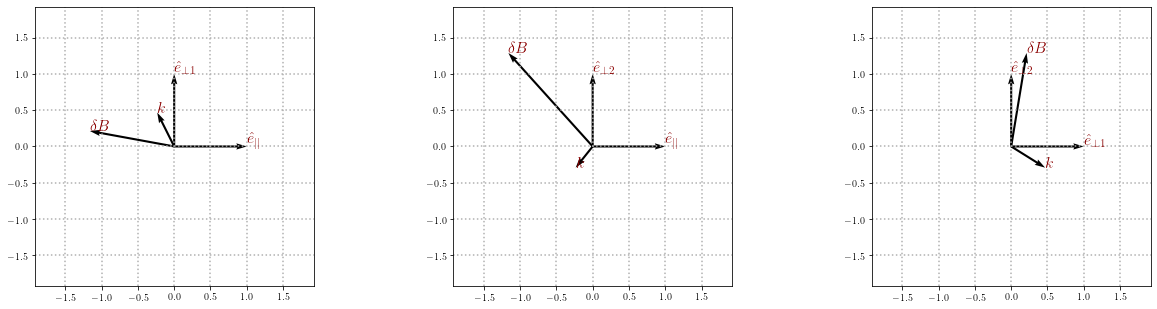

In [38]:
pltdebug.plot_flucs_on_field_aligned_coords(dfields,k,delB,xlim,ylim,zlim)

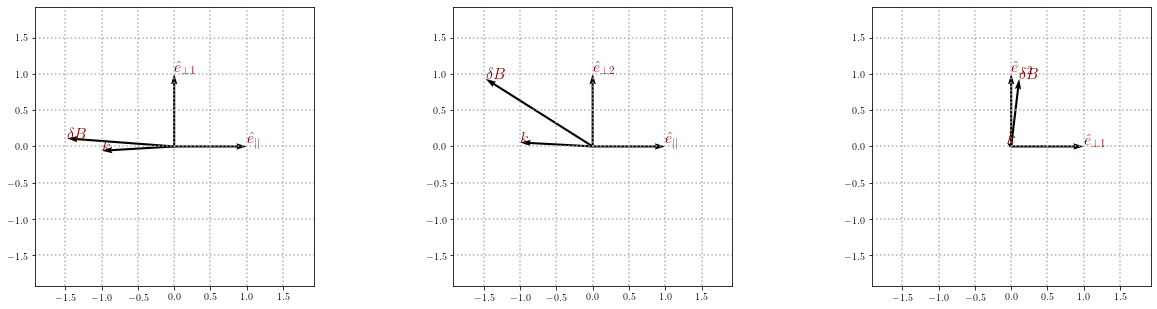

In [39]:
#TEST transformation (e_|| is in the xz plane, so k = [0,1,0] should have no e_perp2 = x cross b comp.)
pltdebug.plot_flucs_on_field_aligned_coords(dfields,[0,1,0],delB,[44,45],ylim,zlim)

making plot 1...


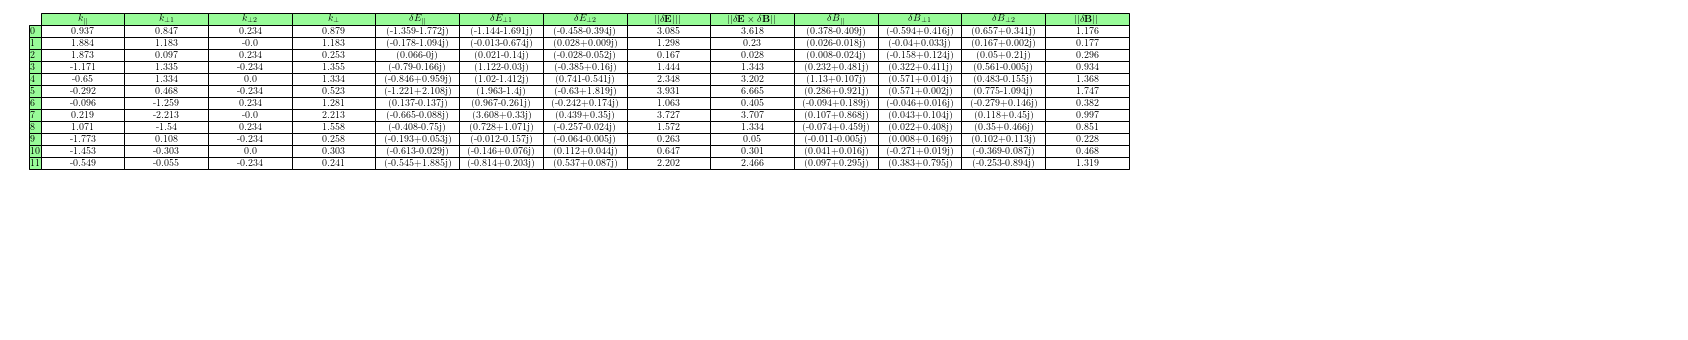

making plot 2...


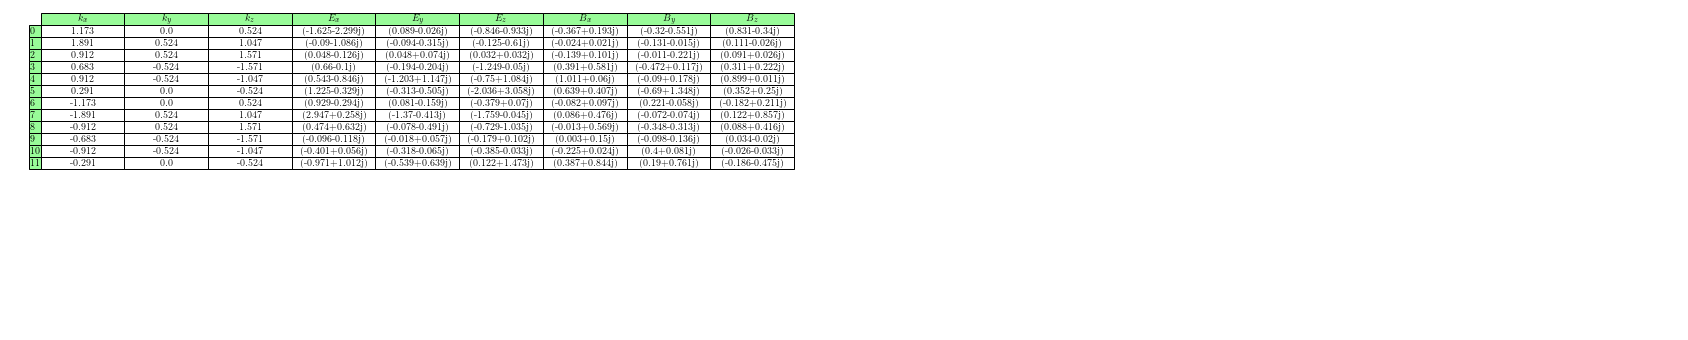

In [64]:
#make table
data = []
data2 = []
rowlbls = []
for i in range(0,len(kxlist)):
    k = [kxlist[i],kylist[i],kzlist[i]]
    kx = k[0]
    ky = k[1]
    kz = k[2]
    Ex = delElist[i][0]
    Ey = delElist[i][1]
    Ez = delElist[i][2]
    Bx = delBlist[i][0]
    By = delBlist[i][1]
    Bz = delBlist[i][2]
    kpar = np.dot(epar,k)
    kperp1 = np.dot(eperp1,k)
    kperp2 = np.dot(eperp2,k)
    kperp = math.sqrt(kperp1**2+kperp2**2)
    Epar = np.dot(epar,delElist[i])
    Eperp1 = np.dot(eperp1,delElist[i])
    Eperp2 = np.dot(eperp2,delElist[i])
    Bpar = np.dot(epar,delBlist[i])
    Bperp1 = np.dot(eperp1,delBlist[i])
    Bperp2 = np.dot(eperp2,delBlist[i])
    normE = np.linalg.norm(delElist[i])
    normB = np.linalg.norm(delBlist[i])
    EcrossB = np.linalg.norm(np.cross([Epar,Eperp1,Eperp2],[Bpar,Bperp1,Bperp2]))
    row = [kpar,kperp1,kperp2,kperp,Epar,Eperp1,Eperp2,normE,EcrossB,Bpar,Bperp1,Bperp2,normB]
    row2 = [kx,ky,kz,Ex,Ey,Ez,Bx,By,Bz]
    
    for j in range(0,len(row)):
        row[j] = np.round(row[j],3)
    for j in range(0,len(row2)):
        row2[j] = np.round(row2[j],3)
    
    
    data.append(row)
    data2.append(row2)
    rowlbls.append(str(i))
    
# #sort data by deltaB
# data = np.asarray(data)
# data = data[data[:,11].argsort()]
    
#collbls = ['kpar','kperp1','kperp2','Epar','Eperp1','Eperp2','normE','Bpar','Bperp1','Bperp2','normB']   
collbls = [r'$k_{||}$',r'$k_{\perp 1}$',r'$k_{\perp 2}$',r'$k_\perp$',r'$\delta E_{||}$',r'$\delta E_{\perp 1}$',r'$\delta E_{\perp 2}$',r'$||\delta \mathbf{E}|||$',r'$||\delta \mathbf{E} \times \delta \mathbf{B}||$',r'$\delta B_{||}$',r'$\delta B_{\perp 1}$',r'$\delta B_{\perp 2}$',r'$||\delta \mathbf{B}||$']
print('making plot 1...')
plttbl.make_table(rowlbls,collbls,data,flnm='fieldalignedmodestablev2')
plttbl.make_table(rowlbls,collbls,data,flnm='')

print('making plot 2...')
collbls = [r'$k_{x}$',r'$k_{y}$',r'$k_{z}$',r'$E_{x}$',r'$E_{y}$',r'$E_{z}$',r'$B_{x}$',r'$B_{y}$',r'$B_{z}$']
plttbl.make_table(rowlbls,collbls,data2,flnm='boxalignedmodestablev2')
plttbl.make_table(rowlbls,collbls,data2,flnm='')

### Look at example wlt 

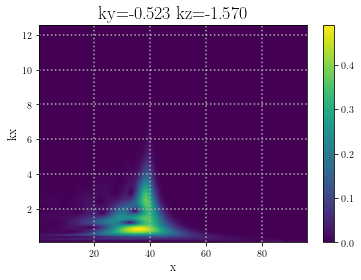

In [40]:
#TODO: generate plots related to the true part here
i = 3
pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = '', xlim = None, ylim = None)

### Improve selecting Kx(s) using wlt
Current algo just grabs the strongest kx at given xx of wlt

In [67]:
wlttemp = wltplotlist[0]
xxs = dfields['bz_xx']
xidx = ao.find_nearest(xxs,40)
wltslice = np.abs(wlttemp[:,xidx])


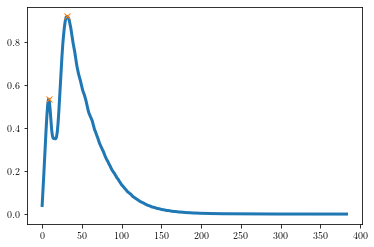

[8, 31]

In [68]:
ao.find_local_maxima(wltslice,threshold = .05,pltdebug = True)

## Build/ analyze delta B(kz,ky,kx;x) and delta E(kz,ky,kx;x)

In [546]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)
dflowfluc = anl.remove_average_flow_over_yz(dflow)

In [575]:
kz, ky, kx, bxkzkykxxx = anl.transform_field_to_kzkykxxx(dfieldsfluc,'bx',retstep=12)
kz, ky, kx, bykzkykxxx = anl.transform_field_to_kzkykxxx(dfieldsfluc,'by',retstep=12)
kz, ky, kx, bzkzkykxxx = anl.transform_field_to_kzkykxxx(dfieldsfluc,'bz',retstep=12)
kz, ky, kx, exkzkykxxx = anl.transform_field_to_kzkykxxx(dfieldsfluc,'ex',retstep=12)
kz, ky, kx, eykzkykxxx = anl.transform_field_to_kzkykxxx(dfieldsfluc,'ey',retstep=12)
kz, ky, kx, ezkzkykxxx = anl.transform_field_to_kzkykxxx(dfieldsfluc,'ez',retstep=12)
kz, ky, kx, uxkzkykxxx = anl.transform_field_to_kzkykxxx(dflowfluc,'ux',retstep=12)
kz, ky, kx, uykzkykxxx = anl.transform_field_to_kzkykxxx(dflowfluc,'uy',retstep=12)
kz, ky, kx, uzkzkykxxx = anl.transform_field_to_kzkykxxx(dflowfluc,'uz',retstep=12)

In [680]:
dwavemodes = wm.compute_wavemodes(xx,dfields,xlim,ylim,zlim,
                     kx,ky,kz,
                     bxkzkykxxx,bykzkykxxx,bzkzkykxxx,
                     exkzkykxxx,eykzkykxxx,ezkzkykxxx,
                     uxkzkykxxx,uykzkykxxx,uzkzkykxxx)

In [681]:
dwavemodes = wm.sort_wavemodes(dwavemodes,'normB')

In [960]:
dwavemodes['wavemodes'][0]['kx']

0.8463434203587333

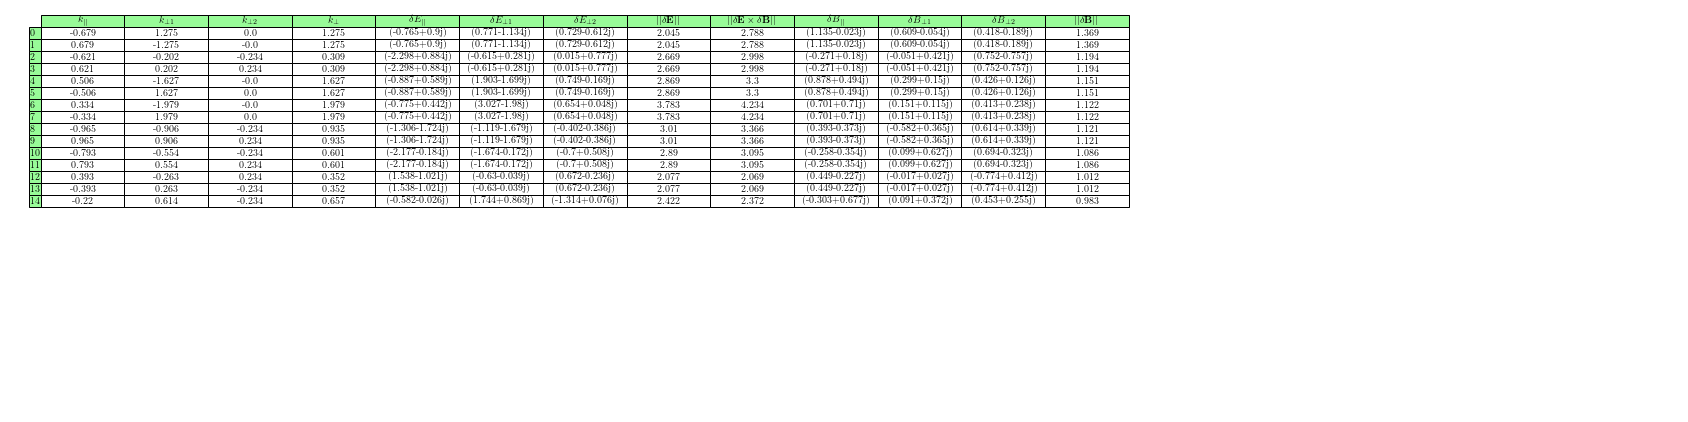

In [952]:
table1keys = ['kpar','kperp1','kperp2','kperp','Epar','Eperp1','Eperp2','normE','normEcrossB','Bpar','Bperp1','Bperp2','normB']
wm.wavemodes_table(dwavemodes,table1keys,15,writeToText=False)

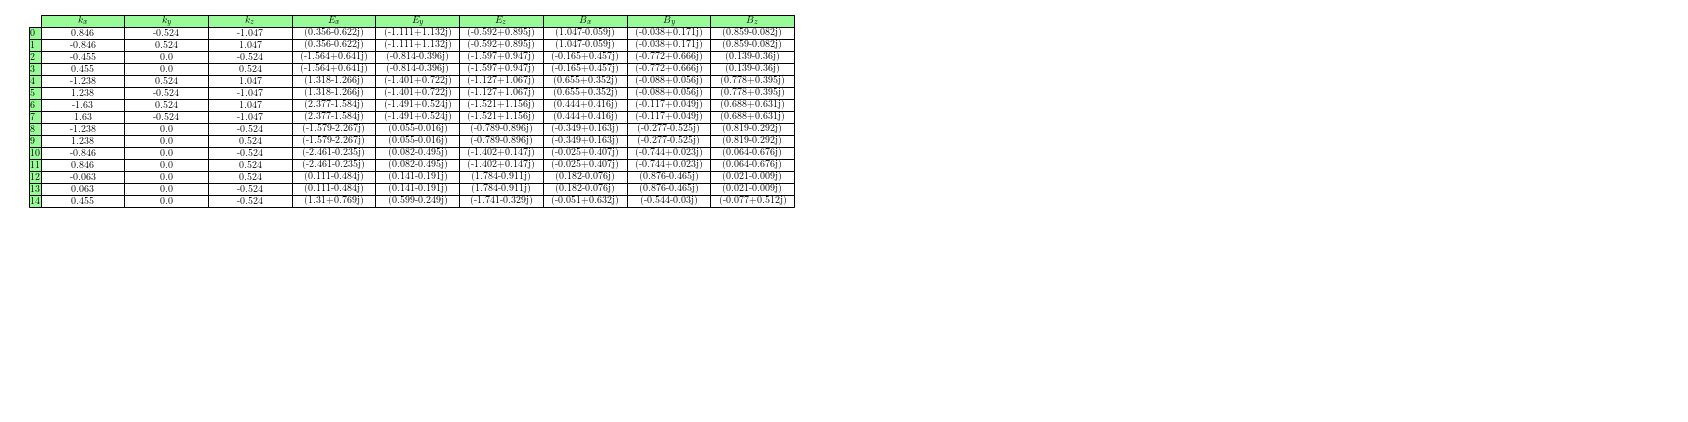

In [684]:
table2keys = ['kx','ky','kz','Ex','Ey','Ez','Bx','By','Bz']
wm.wavemodes_table(dwavemodes,table2keys,15,writeToText=False)

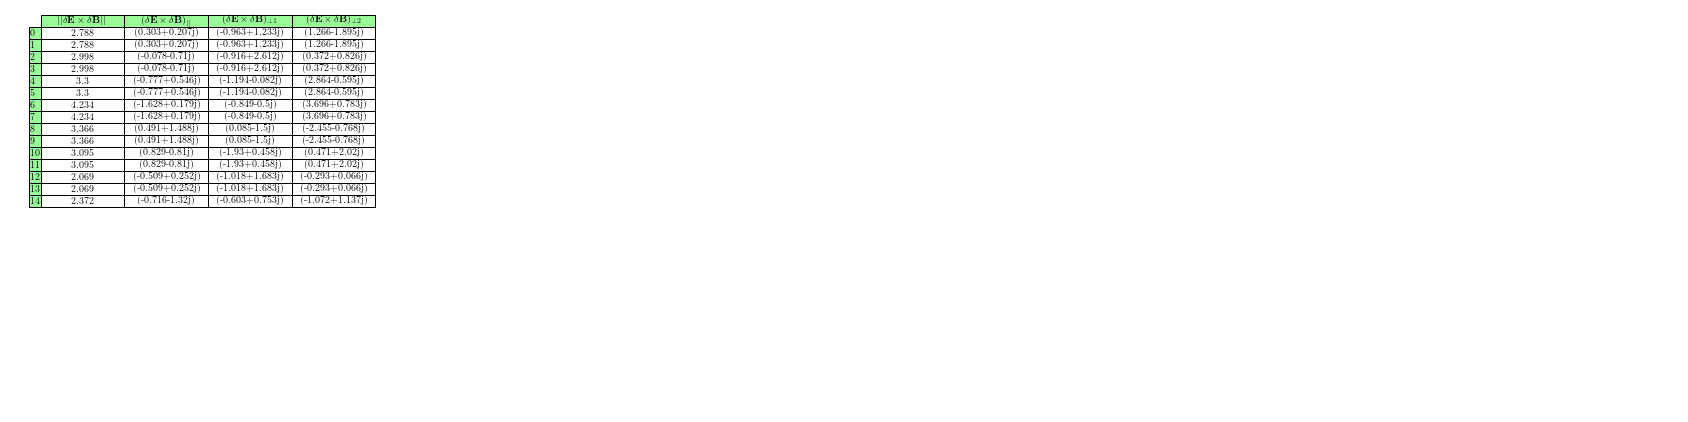

In [687]:
table3keys = ['normEcrossB','EcrossBpar','EcrossBperp1','EcrossBperp2']
wm.wavemodes_table(dwavemodes,table3keys,15,writeToText=False)

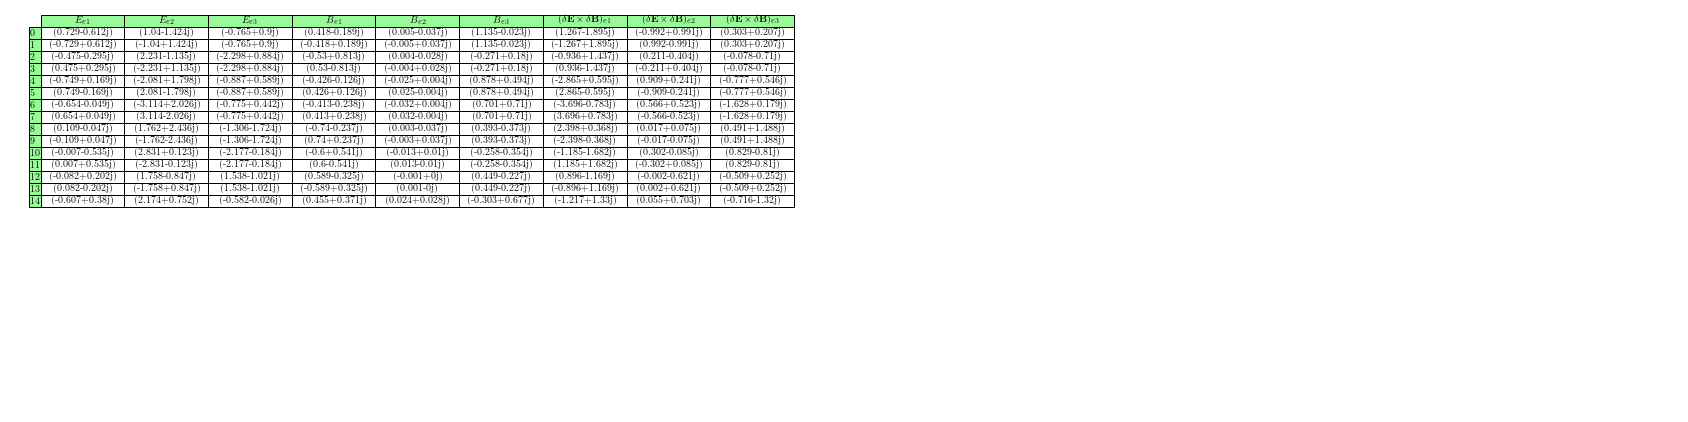

In [688]:
table4keys = ['Ee1','Ee2','Ee3','Be1','Be2','Be3','EcrossBe1','EcrossBe2','EcrossBe3']
wm.wavemodes_table(dwavemodes,table4keys,15,writeToText=False)

### Filter fields to wave number

In [178]:
#first we just filter along yz

In [177]:
path_particles = path+"/Output/Raw/Sp01/raw_sp01_{:08d}.h5"
xlim = [37,45]
ylim = [0,1]
zlim = [0,1]
dpar = dh5.read_box_of_particles(path_particles, numframe, xlim[0], xlim[1], ylim[0], ylim[1], zlim[0], zlim[1])

In [ ]:
dffiltered = anl.yz_fft_filter(dfields,.524,1.047)

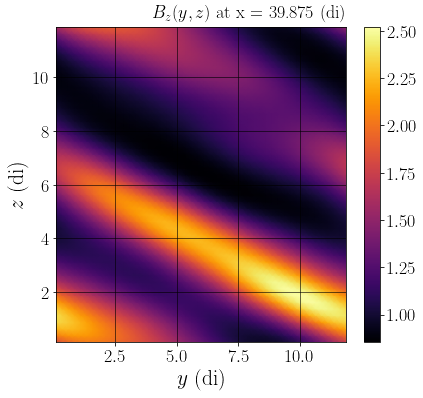

In [534]:
#plot before 
plt2d.make_field_pmesh(dfields,'bz','yz',takeaxisaverage=False,xxindex=xxidx)

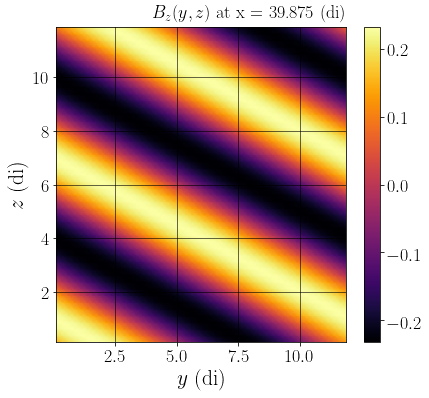

In [535]:
#plot after 
plt2d.make_field_pmesh(dffiltered,'bz','yz',takeaxisaverage=False,xxindex=xxidx)

### Plot dUx

In [526]:
dflowfluc = anl.remove_average_flow_over_yz(dflow)

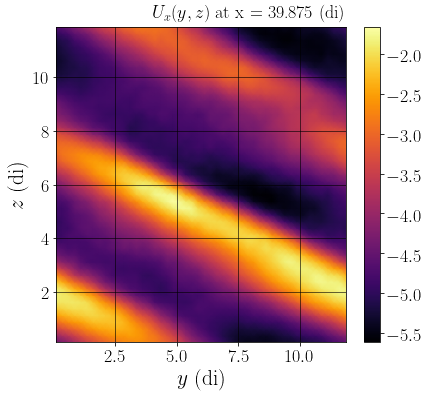

In [530]:
plt2d.make_field_pmesh(dflow,'ux','yz',takeaxisaverage=False,xxindex=xxidx)

### Look at j dot E
TODO look at field flucs j dot E

In [827]:
_dx = dfields['bz_xx'][1]-dfields['bz_xx'][0]
_xx = dfields['bz_xx'][0]
xposarray = []
jxEx = []
jyEy = []
jzEz = []
for ind in range(0,len(dfields['bz_xx'])):
    _jxEx,_jyEy,_jzEz = anl.calc_Ji_Ei(dfields, dflow, _xx, _xx+dx, ylim[0], ylim[1], zlim[0], zlim[1])
    jxEx.append(_jxEx)
    jyEy.append(_jyEy)
    jzEz.append(_jzEz)
    xposarray.append(np.mean([_xx,_xx+dx]))
    _xx += dx
jxEx = np.asarray(jxEx)
jyEy = np.asarray(jyEy)
jzEz = np.asarray(jzEz)
jdotE = jxEx+jyEy+jzEz

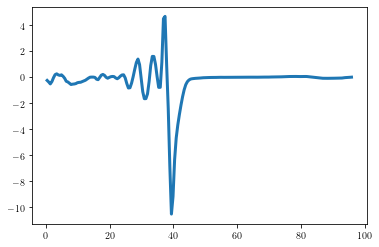

In [828]:
plt.figure()
plt.plot(xposarray,jdotE)
plt.show()

## Eigen function analysis
and comparison with plume results

#### Look at wavemodes corresponding to rip1a sweep

In [1151]:
#TODO: id sweeps

In [1152]:
testsweep0 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip1a_kpar_100_10000.mode1')
testsweep1 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip1a_kpar_100_10000.mode2')
testsweep2 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip1a_kpar_100_10000.mode3')
testsweep3 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip1a_kpar_100_10000.mode4')
testsweep4 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip1a_kpar_100_10000.mode5')
testsweep5 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip1a_kpar_100_10000.mode6')
testsweep6 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip1a_kpar_100_10000.mode7')
testsweep7 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip1a_kpar_100_10000.mode8')

In [1153]:
testwmode = plm.rotate_and_norm_to_plume_basis(dwavemodes['wavemodes'][6],dwavemodes['epar'],dwavemodes['eperp1'],dwavemodes['eperp2'])

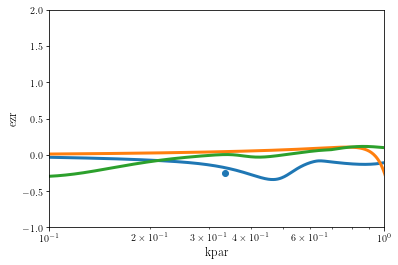

In [1154]:
pltplm.plot_sweep([testsweep1,testsweep3,testsweep4],'kpar','ezr',wavemodes=[testwmode],xlim=[.1,1],ylim=[-1,2])

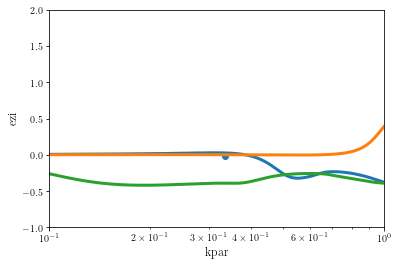

In [1155]:
pltplm.plot_sweep([testsweep1,testsweep3,testsweep4],'kpar','ezi',wavemodes=[testwmode],xlim=[.1,1],ylim=[-1,2])

#### Look at wavemodes corresponding to rip2a sweep

In [1156]:
#TODO: id sweeps

In [1157]:
testsweep0 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip2a_kpar_100_10000.mode1')
testsweep1 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip2a_kpar_100_10000.mode2')
testsweep2 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip2a_kpar_100_10000.mode3')
testsweep3 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip2a_kpar_100_10000.mode4')
testsweep4 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip2a_kpar_100_10000.mode5')
testsweep5 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip2a_kpar_100_10000.mode6')
testsweep6 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip2a_kpar_100_10000.mode7')
testsweep7 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip2a_kpar_100_10000.mode8')

In [1162]:
testwmode = plm.rotate_and_norm_to_plume_basis(dwavemodes['wavemodes'][4],dwavemodes['epar'],dwavemodes['eperp1'],dwavemodes['eperp2'])

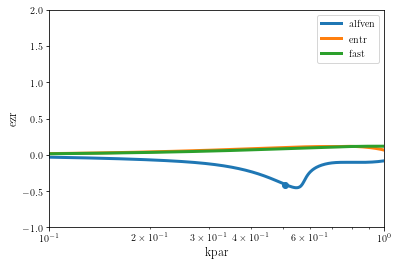

In [1163]:
pltplm.plot_sweep([testsweep1,testsweep3,testsweep4],'kpar','ezr',wavemodes=[testwmode],xlim=[.1,1],ylim=[-1,2],lbls=['alfven','entr','fast'])

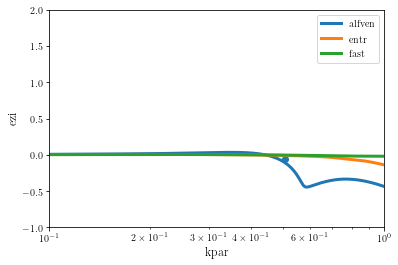

In [1164]:
pltplm.plot_sweep([testsweep1,testsweep3,testsweep4],'kpar','ezi',wavemodes=[testwmode],xlim=[.1,1],ylim=[-1,2],lbls=['alfven','entr','fast'])

#### Look at wavemodes corresponding to rip3a sweep

In [1168]:
#for rip3a.in: 3 -> entropy, 1-> alfven, 4-> fast, slow was not found

In [1169]:
testsweep0 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip3a_kpar_100_10000.mode1')
testsweep1 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip3a_kpar_100_10000.mode2')
testsweep2 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip3a_kpar_100_10000.mode3')
testsweep3 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip3a_kpar_100_10000.mode4')
testsweep4 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip3a_kpar_100_10000.mode5')
testsweep5 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip3a_kpar_100_10000.mode6')
testsweep6 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip3a_kpar_100_10000.mode7')
testsweep7 = plm.load_plume_sweep('PLUME/pack_plume_210324/data/shock/rip3a_kpar_100_10000.mode8')

In [1172]:
testwmode = plm.rotate_and_norm_to_plume_basis(dwavemodes['wavemodes'][1],dwavemodes['epar'],dwavemodes['eperp1'],dwavemodes['eperp2'])

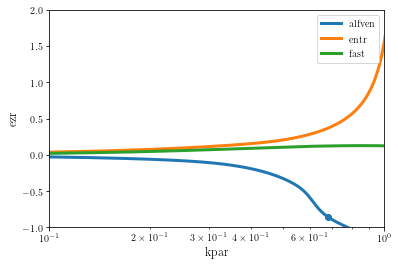

In [1173]:
pltplm.plot_sweep([testsweep1,testsweep3,testsweep4],'kpar','ezr',wavemodes=[testwmode],xlim=[.1,1],ylim=[-1,2],lbls=['alfven','entr','fast'])

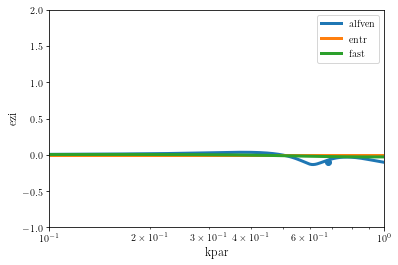

In [1174]:
pltplm.plot_sweep([testsweep1,testsweep3,testsweep4],'kpar','ezi',wavemodes=[testwmode],xlim=[.1,1],ylim=[-1,2],lbls=['alfven','entr','fast'])

### make sure wlt commutes

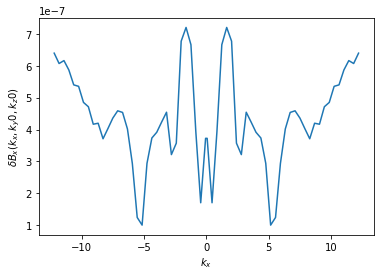

In [30]:
import matplotlib.pyplot as plt
xxidx = int(nkx/2)
plt.figure()
plt.plot(kx,np.abs(bxkzkykxxx[0,0,:,xxidx]))
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_x(k_x,k_y0,k_z0)$')
plt.show()

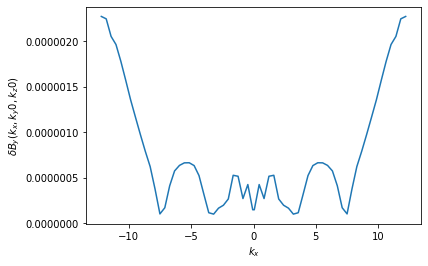

In [31]:

plt.figure()
plt.plot(kx,np.abs(bykzkykxxx[0,0,:,xxidx]))
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_y(k_x,k_y0,k_z0)$')
plt.show()

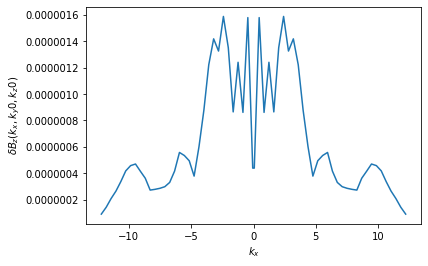

In [32]:
plt.figure()
plt.plot(kx,np.abs(bzkzkykxxx[0,0,:,xxidx]))
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_z(k_x,k_y0,k_z0)$')
plt.show()

In [113]:
ky

0.0

In [114]:
#test commutivity
retstep = 12
nxx = len(dfieldsfluc['bz_xx'])
nkx = int(len(dfieldsfluc['bz_xx'])/retstep) #warning: this is hard coded to match wlt function output
#nky = len(ky)
#nkz = len(kz)

#get kz
bxkzkykxxx = np.zeros((nkz,nky,2*nkx,nxx),dtype=np.complex_)
bykzkykxxx = np.zeros((nkz,nky,2*nkx,nxx),dtype=np.complex_)
bzkzkykxxx = np.zeros((nkz,nky,2*nkx,nxx),dtype=np.complex_)

#compute delta fields
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

#take wlt to build B(z,y,kx,xx)
#TODO: rename kzidx/kyidx
for kzidx in range(0,nkz):
    for kyidx in range(0,nky):
        positivekx, rightbxkz0ky0kxxx = anl.wlt(dfieldsfluc['bx_xx'],dfieldsfluc['bx'][kzidx,kyidx,:],retstep=retstep)
        positivekx, rightbykz0ky0kxxx = anl.wlt(dfieldsfluc['by_xx'],dfieldsfluc['by'][kzidx,kyidx,:],retstep=retstep)
        positivekx, rightbzkz0ky0kxxx = anl.wlt(dfieldsfluc['bz_xx'],dfieldsfluc['bz'][kzidx,kyidx,:],retstep=retstep)
        
        negativekx, leftbxkz0ky0kxxx = anl.wlt(dfieldsfluc['bx_xx'],np.conj(dfieldsfluc['bx'][kzidx,kyidx,:]),retstep=retstep)
        negativekx, leftbykz0ky0kxxx = anl.wlt(dfieldsfluc['by_xx'],np.conj(dfieldsfluc['by'][kzidx,kyidx,:]),retstep=retstep)
        negativekx, leftbzkz0ky0kxxx = anl.wlt(dfieldsfluc['bz_xx'],np.conj(dfieldsfluc['bz'][kzidx,kyidx,:]),retstep=retstep)
        
        bxkzkykxxx[kzidx,kyidx,nkx:,:] = rightbxkz0ky0kxxx[:,:]
        bykzkykxxx[kzidx,kyidx,nkx:,:] = rightbykz0ky0kxxx[:,:]
        bzkzkykxxx[kzidx,kyidx,nkx:,:] = rightbzkz0ky0kxxx[:,:]
        
        bxkzkykxxx[kzidx,kyidx,0:nkx,:] = np.flip(leftbxkz0ky0kxxx[:,:], axis=0)
        bykzkykxxx[kzidx,kyidx,0:nkx,:] = np.flip(leftbykz0ky0kxxx[:,:], axis=0)
        bzkzkykxxx[kzidx,kyidx,0:nkx,:] = np.flip(leftbzkz0ky0kxxx[:,:], axis=0)
negativekx *= -1
negativekx = np.sort(negativekx)
kx = np.concatenate([negativekx,positivekx])
        
#take fft2 to build B(kz,ky,kx,xx)
for kxidx in range(0,2*nkx):
    for xidx in range(0,nxx):
        bxkzkykx0xx0 = np.fft.fft2(bxkzkykxxx[:,:,kxidx,xidx])
        bykzkykx0xx0 = np.fft.fft2(bykzkykxxx[:,:,kxidx,xidx])
        bzkzkykx0xx0 = np.fft.fft2(bzkzkykxxx[:,:,kxidx,xidx])
        
        bxkzkykxxx[:,:,kxidx,xidx] = bxkzkykx0xx0
        bykzkykxxx[:,:,kxidx,xidx] = bykzkykx0xx0
        bzkzkykxxx[:,:,kxidx,xidx] = bzkzkykx0xx0
        
from copy import deepcopy
bxkzkykxxx_method2 = deepcopy(bxkzkykxxx)
bykzkykxxx_method2 = deepcopy(bykzkykxxx)
bzkzkykxxx_method2 = deepcopy(bzkzkykxxx)

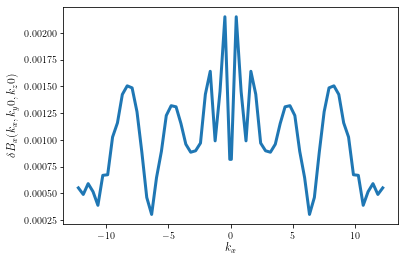

In [115]:
plt.figure()
plt.plot(kx,np.abs(bxkzkykxxx[0,0,:,xxidx]))
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_x(k_x,k_y0,k_z0)$')
plt.show()

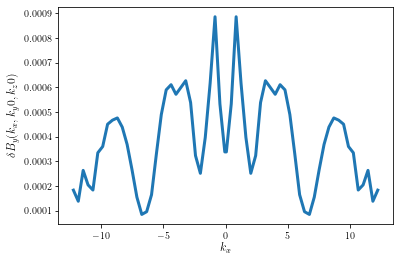

In [116]:
plt.figure()
plt.plot(kx,np.abs(bykzkykxxx[0,0,:,xxidx]))
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_y(k_x,k_y0,k_z0)$')
plt.show()

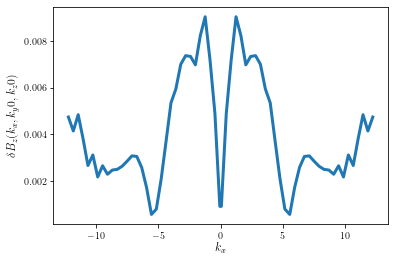

In [117]:
plt.figure()
plt.plot(kx,np.abs(bzkzkykxxx[0,0,:,xxidx]))
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_z(k_x,k_y0,k_z0)$')
plt.show()

In [136]:
#compare both methods
kz, ky, bxkzkyx = anl._ffttransform_in_yz(dfieldsfluc,'bx') #just to grab kz, ky

In [121]:
bxkzkykxxx_method1_norm = bxkzkykxxx_method1 / np.max(bxkzkykxxx_method1)

In [122]:
bxkzkykxxx_method2_norm = bxkzkykxxx_method2 / np.max(bxkzkykxxx_method2)

In [131]:
bxkzkykxxx_method1_norm[1,1,1,1]

(-8.372429343171922e-05-0.00010835791623159417j)

In [132]:
bxkzkykxxx_method2_norm[1,1,1,1]

(9.717306963461014e-05-9.851670323733785e-05j)

In [137]:
ky

array([  0.        ,   0.52359878,   1.04719755,   1.57079633,
         2.0943951 ,   2.61799388,   3.14159265,   3.66519143,
         4.1887902 ,   4.71238898,   5.23598776,   5.75958653,
         6.28318531,   6.80678408,   7.33038286,   7.85398163,
         8.37758041,   8.90117919,   9.42477796,   9.94837674,
        10.47197551,  10.99557429,  11.51917306,  12.04277184,
       -12.56637061, -12.04277184, -11.51917306, -10.99557429,
       -10.47197551,  -9.94837674,  -9.42477796,  -8.90117919,
        -8.37758041,  -7.85398163,  -7.33038286,  -6.80678408,
        -6.28318531,  -5.75958653,  -5.23598776,  -4.71238898,
        -4.1887902 ,  -3.66519143,  -3.14159265,  -2.61799388,
        -2.0943951 ,  -1.57079633,  -1.04719755,  -0.52359878])

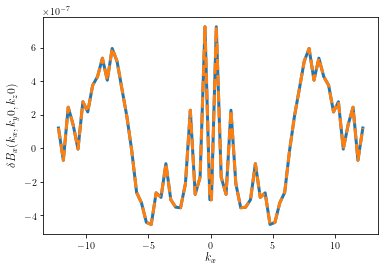

In [148]:
plt.figure()
plt.plot(kx,bxkzkykxxx_method1_norm[0,0,:,xxidx])
plt.plot(kx,bxkzkykxxx_method2_norm[0,0,:,xxidx], '--')
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_x(k_x,k_y0,k_z0)$')
plt.show()

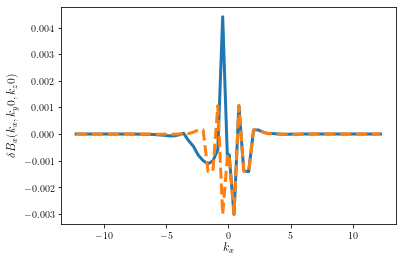

In [149]:
plt.figure()
plt.plot(kx,bxkzkykxxx_method1_norm[5,5,:,xxidx])
plt.plot(kx,bxkzkykxxx_method2_norm[5,5,:,xxidx], '--')
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_x(k_x,k_y0,k_z0)$')
plt.show()

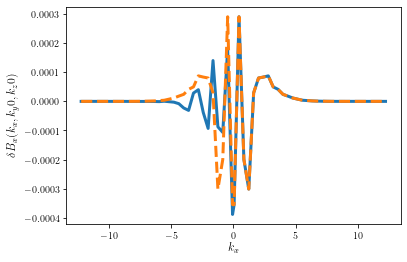

In [150]:
plt.figure()
plt.plot(kx,bxkzkykxxx_method1_norm[3,7,:,xxidx])
plt.plot(kx,bxkzkykxxx_method2_norm[3,7,:,xxidx], '--')
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_x(k_x,k_y0,k_z0)$')
plt.show()

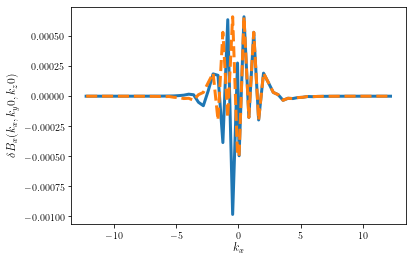

In [151]:
plt.figure()
plt.plot(kx,bxkzkykxxx_method1_norm[0,7,:,xxidx])
plt.plot(kx,bxkzkykxxx_method2_norm[0,7,:,xxidx], '--')
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_x(k_x,k_y0,k_z0)$')
plt.show()

//anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


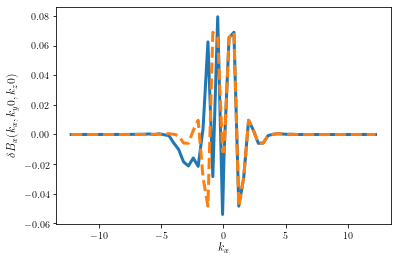

In [152]:
plt.figure()
plt.plot(kx,bxkzkykxxx_method1_norm[3,0,:,xxidx])
plt.plot(kx,bxkzkykxxx_method2_norm[3,0,:,xxidx], '--')
plt.xlabel('$k_x$')
plt.ylabel('$\delta B_x(k_x,k_y0,k_z0)$')
plt.show()

In [159]:
#test k dot b for wlt, ky, kz
_kzidx = 0
_kyidx = 5
_kxidx = len(kx)-1
_xxidx = 0

_kvec = [kx[_kxidx],ky[_kyidx],kz[_kzidx]]
_delBvec = [bxkzkykxxx_method1[_kzidx,_kyidx,_kxidx,_xxidx],bykzkykxxx_method1[_kzidx,_kyidx,_kxidx,_xxidx],bzkzkykxxx_method1[_kzidx,_kyidx,_kxidx,_xxidx]]
np.dot(_kvec,_delBvec)

(0.0002739273558279409-0.00018434901704032392j)

## Bad/ Old code

#### Work on attempting to compute \delta B (k_perp, k_{||}) from  \delta B (k_perp1,k_perp2, k_{||})

In [33]:
# # make the bins 3d arrays
# _kx = np.zeros((len(kz), len(ky), len(kx)))
# _ky = np.zeros((len(kz), len(ky), len(kx)))
# _kz = np.zeros((len(kz), len(ky), len(kx)))
# for i in range(0, len(kx)):
#     for j in range(0, len(ky)):
#         for k in range(0, len(kz)):
#             _kx[k][j][i] = kx[i]

# for i in range(0, len(kx)):
#     for j in range(0, len(ky)):
#         for k in range(0, len(kz)):
#             _ky[k][j][i] = ky[j]

# for i in range(0, len(kx)):
#     for j in range(0, len(ky)):
#         for k in range(0, len(kz)):
#             _kz[k][j][i] = kz[k]
            
# kx = _kx
# ky = _ky
# kz = _kz

In [34]:
# # transform coordinates
# B0 = anl.get_B_yzavg(dfields,xxidx)
# vperp2basis, vperp1basis, vparbasis = anl.compute_field_aligned_coord(dfields,[40,41],ylim,zlim)

# _ = np.asarray([vparbasis,vperp1basis,vperp2basis]).T
# changebasismatrix = np.linalg.inv(_)
# #kpar,kperp1,kperp2 = np.matmul(changebasismatrix,[kx[:],ky[:],kz[:]])
# nkz, nky, nkx = kx.shape
# kpar = np.zeros(kx.shape)
# kperp1 = np.zeros(kx.shape)
# kperp2 = np.zeros(kx.shape)
# # bpar = np.zeros(kx.shape)
# # bperp1 = np.zeros(kx.shape)
# # bperp2 = np.zeros(kx.shape)
# for kidx in range(0,nkz):
#     for jidx in range(0,nky):
#         for iidx in range(0,nkx):
#             _kpar, _kperp1, _kperp2 = np.matmul(changebasismatrix,[kx[kidx,jidx,iidx],ky[kidx,jidx,iidx],kz[kidx,jidx,iidx]])
#             kpar[kidx,jidx,iidx] = _kpar
#             kperp1[kidx,jidx,iidx] = _kperp1
#             kperp2[kidx,jidx,iidx] = _kperp2

# kpar = np.asarray(kpar)
# kperp1 = np.asarray(kperp1)
# kperp2 = np.asarray(kperp2)

## bad attempt to predict kx

In [41]:

# for i in range(0,len(kxplotlist)):
#     #plot what kx would need to be given ky kz along some 
#     k = [kxlist[i],kylist[i],kzlist[i]]
#     xxvals = []
#     kxvals = []

#     kz, ky, bxkzkyx = anl._ffttransform_in_yz(dfieldsfluc,'bx')
#     kz, ky, bykzkyx = anl._ffttransform_in_yz(dfieldsfluc,'by')
#     kz, ky, bzkzkyx = anl._ffttransform_in_yz(dfieldsfluc,'bz')

#     for xidx in range(0,len(dfields['bz_xx'])):
#         B0 = anl.get_B0(dfields,xxidx)
        
#         xxidx = xidx
#         kperp = anl._get_perp_component(k,B0)

#         #find nearest discrete point in (x,ky,kz) space we have data for
#         kyidx = ao.find_nearest(ky,k[1])
#         kzidx = ao.find_nearest(kz,k[2])
#         kyperpidx = ao.find_nearest(ky,kperp[1])
#         kzperpidx = ao.find_nearest(kz,kperp[2])

#         #finalize transform into k space i.e. compute B(kx0,kz0,ky0) from B(x,kz,ky) for k and k perp
#         #note: we never have an array B(kx,ky,kz), just that scalar quantities at k0 and kperp0, which we get from
#         # the just for B(x,kz,ky) as computing the entire B(kx,ky,kz) array would be computationally expensive.
#         # would have to perform wavelet transform for each (ky0,kz0)
#         kx, bxkz0ky0kxxx = anl.wlt(dfieldsfluc['bx_xx'],bxkzkyx[:,kzidx,kyidx]) #note kx is that same for all 6 returns here
#         kx, bykz0ky0kxxx = anl.wlt(dfieldsfluc['by_xx'],bykzkyx[:,kzidx,kyidx])
#         kx, bzkz0ky0kxxx = anl.wlt(dfieldsfluc['bz_xx'],bzkzkyx[:,kzidx,kyidx])
#         kx, bxperpkz0ky0kxxx = anl.wlt(dfieldsfluc['bx_xx'],bxkzkyx[:,kzperpidx,kyperpidx])
#         kx, byperpkz0ky0kxxx = anl.wlt(dfieldsfluc['by_xx'],bykzkyx[:,kzperpidx,kyperpidx])
#         kx, bzperpkz0ky0kxxx = anl.wlt(dfieldsfluc['bz_xx'],bzkzkyx[:,kzperpidx,kyperpidx])

#         kxidx = ao.find_nearest(kx,np.abs(k[0])) #WLT can not find negative kx. Instead we assume symmetry by taking np.abs
#         kxperpidx = ao.find_nearest(kx,np.abs(kperp[0]))

#         if(k[0] < 0): #use reality condition to correct for the fact that we cant compute negative kx using the wlt
#             bxkz0ky0kxxx = np.conj(bxkz0ky0kxxx)
#             bykz0ky0kxxx = np.conj(bykz0ky0kxxx)
#             bzkz0ky0kxxx = np.conj(bzkz0ky0kxxx)
#             bxperpkz0ky0kxxx = np.conj(bxperpkz0ky0kxxx)
#             byperpkz0ky0kxxx = np.conj(byperpkz0ky0kxxx)
#             bzperpkz0ky0kxxx = np.conj(bzperpkz0ky0kxxx)

#         kcrossB0 = np.cross(k,B0)
#         delB = [bxkz0ky0kxxx[kxidx,xxidx],bykz0ky0kxxx[kxidx,xxidx],bzkz0ky0kxxx[kxidx,xxidx]]
#         delBperp = [bxperpkz0ky0kxxx[kxperpidx,xxidx],byperpkz0ky0kxxx[kxperpidx,xxidx],bzperpkz0ky0kxxx[kxperpidx,xxidx]]

#         kxvals.append(anl.predict_kx_alfven(xxidx,k,kx,B0,bxperpkz0ky0kxxx,byperpkz0ky0kxxx,bzperpkz0ky0kxxx))
#         xxvals.append(dfields['bz_xx'][xidx])
#     pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = '', plotstrongestkx = True, ylim = [0,7], xxline = xxvals, yyline = kxvals)
#     pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = "ky0"+str(kylist[i])+"kz0"+str(kzlist[i])+'wltkxprediction.png', plotstrongestkx = False, ylim = [0,7], xxline = xxvals, yyline = kxvals)

AttributeError: module 'lib.analysis' has no attribute 'get_B0'

### Old wave to transform using fft for yz and wlt for x

In [102]:
# #we will need B(kx,ky,kz;x)
# #TODO: put into function

# retstep = 12 #variable used to reduce size of array

# #compute delta fields
# dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

# fieldkey = 'bz'

# #spacing in grids, needed to get wavenumber from fft
# daxis0 = dfieldsfluc[fieldkey+'_zz'][1]-dfieldsfluc[fieldkey+'_zz'][0]
# daxis1 = dfieldsfluc[fieldkey+'_yy'][1]-dfieldsfluc[fieldkey+'_yy'][0]

# kz, ky, bxkzkyx = anl._ffttransform_in_yz(dfieldsfluc,'bx')
# kz, ky, bykzkyx = anl._ffttransform_in_yz(dfieldsfluc,'by')
# kz, ky, bzkzkyx = anl._ffttransform_in_yz(dfieldsfluc,'bz')
# kz, ky, exkzkyx = anl._ffttransform_in_yz(dfieldsfluc,'ex')
# kz, ky, eykzkyx = anl._ffttransform_in_yz(dfieldsfluc,'ey')
# kz, ky, ezkzkyx = anl._ffttransform_in_yz(dfieldsfluc,'ez')

# nxx = len(dfieldsfluc['bz_xx'])
# nkx = int(len(dfieldsfluc['bz_xx'])/retstep) #warning: this is hard coded to match wlt function output
# nky = len(ky)
# nkz = len(kz)

# #get kz
# bxkzkykxxx = np.zeros((nkz,nky,2*nkx,nxx),dtype=np.complex_)
# bykzkykxxx = np.zeros((nkz,nky,2*nkx,nxx),dtype=np.complex_)
# bzkzkykxxx = np.zeros((nkz,nky,2*nkx,nxx),dtype=np.complex_)
# exkzkykxxx = np.zeros((nkz,nky,2*nkx,nxx),dtype=np.complex_)
# eykzkykxxx = np.zeros((nkz,nky,2*nkx,nxx),dtype=np.complex_)
# ezkzkykxxx = np.zeros((nkz,nky,2*nkx,nxx),dtype=np.complex_)
# for kyidx in range(0,len(ky)):
#     print(str(kyidx)+' of '+str(len(ky)))
#     for kzidx in range(0,len(kz)):

#         positivekx, rightbxkz0ky0kxxx = anl.wlt(dfieldsfluc['bx_xx'],bxkzkyx[:,kzidx,kyidx],retstep=retstep)
#         positivekx, rightbykz0ky0kxxx = anl.wlt(dfieldsfluc['by_xx'],bykzkyx[:,kzidx,kyidx],retstep=retstep)
#         positivekx, rightbzkz0ky0kxxx = anl.wlt(dfieldsfluc['bz_xx'],bzkzkyx[:,kzidx,kyidx],retstep=retstep)
#         positivekx, rightexkz0ky0kxxx = anl.wlt(dfieldsfluc['ex_xx'],exkzkyx[:,kzidx,kyidx],retstep=retstep)
#         positivekx, righteykz0ky0kxxx = anl.wlt(dfieldsfluc['ey_xx'],eykzkyx[:,kzidx,kyidx],retstep=retstep)
#         positivekx, rightezkz0ky0kxxx = anl.wlt(dfieldsfluc['ez_xx'],ezkzkyx[:,kzidx,kyidx],retstep=retstep)
        
#         negativekx, leftbxkz0ky0kxxx = anl.wlt(dfieldsfluc['bx_xx'],np.conj(bxkzkyx[:,kzidx,kyidx]),retstep=retstep)
#         negativekx, leftbykz0ky0kxxx = anl.wlt(dfieldsfluc['by_xx'],np.conj(bykzkyx[:,kzidx,kyidx]),retstep=retstep)
#         negativekx, leftbzkz0ky0kxxx = anl.wlt(dfieldsfluc['bz_xx'],np.conj(bzkzkyx[:,kzidx,kyidx]),retstep=retstep)
#         negativekx, leftexkz0ky0kxxx = anl.wlt(dfieldsfluc['ex_xx'],np.conj(exkzkyx[:,kzidx,kyidx]),retstep=retstep)
#         negativekx, lefteykz0ky0kxxx = anl.wlt(dfieldsfluc['ey_xx'],np.conj(eykzkyx[:,kzidx,kyidx]),retstep=retstep)
#         negativekx, leftezkz0ky0kxxx = anl.wlt(dfieldsfluc['ez_xx'],np.conj(ezkzkyx[:,kzidx,kyidx]),retstep=retstep)
        
#         bxkzkykxxx[kzidx,kyidx,nkx:,:] = rightbxkz0ky0kxxx[:,:]
#         bykzkykxxx[kzidx,kyidx,nkx:,:] = rightbykz0ky0kxxx[:,:]
#         bzkzkykxxx[kzidx,kyidx,nkx:,:] = rightbzkz0ky0kxxx[:,:]
#         exkzkykxxx[kzidx,kyidx,nkx:,:] = rightexkz0ky0kxxx[:,:]
#         eykzkykxxx[kzidx,kyidx,nkx:,:] = righteykz0ky0kxxx[:,:]
#         ezkzkykxxx[kzidx,kyidx,nkx:,:] = rightezkz0ky0kxxx[:,:]
        
#         bxkzkykxxx[kzidx,kyidx,0:nkx,:] = np.flip(leftbxkz0ky0kxxx[:,:], axis=0)
#         bykzkykxxx[kzidx,kyidx,0:nkx,:] = np.flip(leftbykz0ky0kxxx[:,:], axis=0)
#         bzkzkykxxx[kzidx,kyidx,0:nkx,:] = np.flip(leftbzkz0ky0kxxx[:,:], axis=0)
#         exkzkykxxx[kzidx,kyidx,0:nkx,:] = np.flip(leftexkz0ky0kxxx[:,:], axis=0)
#         eykzkykxxx[kzidx,kyidx,0:nkx,:] = np.flip(lefteykz0ky0kxxx[:,:], axis=0)
#         ezkzkykxxx[kzidx,kyidx,0:nkx,:] = np.flip(leftezkz0ky0kxxx[:,:], axis=0)
# negativekx *= -1
# negativekx = np.sort(negativekx)
# kx = np.concatenate([negativekx,positivekx])

# from copy import deepcopy
# bxkzkykxxx_method1 = deepcopy(bxkzkykxxx)
# bykzkykxxx_method1 = deepcopy(bykzkykxxx)
# bzkzkykxxx_method1 = deepcopy(bzkzkykxxx)

0 of 48
1 of 48
2 of 48
3 of 48
4 of 48
5 of 48
6 of 48
7 of 48
8 of 48
9 of 48
10 of 48
11 of 48
12 of 48
13 of 48
14 of 48
15 of 48
16 of 48
17 of 48
18 of 48
19 of 48
20 of 48
21 of 48
22 of 48
23 of 48
24 of 48
25 of 48
26 of 48
27 of 48
28 of 48
29 of 48
30 of 48
31 of 48
32 of 48
33 of 48
34 of 48
35 of 48
36 of 48
37 of 48
38 of 48
39 of 48
40 of 48
41 of 48
42 of 48
43 of 48
44 of 48
45 of 48
46 of 48
47 of 48


In [549]:
os.system('ls')

0

In [552]:
os.system('ls -l')

0

In [822]:
%history -g -f 'testrecovercor.txt'

In [820]:
load_plume

NameError: name 'load_plume' is not defined